In [3]:
from langchain_ollama import ChatOllama

llm = ChatOllama(
    model="llama3.2",  # any model you have in Ollama (`ollama pull <model>`)
    base_url="http://localhost:11434",  # default for `ollama serve`
)

In [4]:
from typing_extensions import TypedDict, Literal
from pydantic import BaseModel, Field

class State(TypedDict):
    prompt: str
    initial_response: str
    gate_response: str
    gate_rationale: str
    improved_response: str
    final_response: str

def draft_message(state: State) -> str:
    rsp = llm.invoke(f"Create a mock message sent from a customer for a fictional business.")
    return {"prompt": rsp.content}

def draft_response(state: State) -> str:
    rsp = llm.invoke(
        f"Draft a message response to this customer message to a fictional business: {state['prompt']}"
    )
    return {"initial_response": rsp.content}

class MessageGate(BaseModel):
    decision: Literal["sufficient", "refine"]
    rationale: str = Field(description="Why the draft is ready or needs refinement.")

def gate_response(state: State) -> str:
    message_gate_llm = llm.with_structured_output(MessageGate)
    judgement = message_gate_llm.invoke(f"You're a message reviewer for a business. You must return a decision and a rationale for the message. Message: {state['prompt']}")
    if "sufficient" in judgement.decision:
        return "Pass"
    else:
        return "Fail"

def refine_message(state: State) -> str:
    rsp = llm.invoke(f"Refine this message to a customer: {state['initial_response']}")
    return {"improved_response": rsp.content}

def finalise_message(state: State) -> str:
    rsp = llm.invoke(
        f"This message is ready to be sent to a customer. Please format it to be sent: {state['improved_response']}"
    )
    return {"final_response": rsp.content}

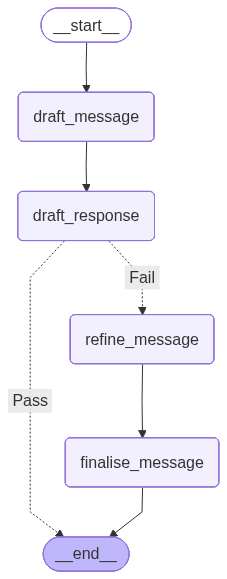

In [5]:
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

workflow = StateGraph(State)
workflow.add_node("draft_message",draft_message)
workflow.add_node("draft_response",draft_response)
workflow.add_node("refine_message",refine_message)
workflow.add_node("finalise_message",finalise_message)

workflow.add_edge(START,"draft_message")
workflow.add_edge("draft_message","draft_response")
workflow.add_conditional_edges("draft_response",gate_response,{"Pass": END, "Fail": "refine_message"})
workflow.add_edge("refine_message","finalise_message")
workflow.add_edge("finalise_message",END)

chain = workflow.compile()

display(Image(chain.get_graph().draw_mermaid_png()))

In [6]:
state = chain.invoke({})
print("Initial message:")
print(state["prompt"])
print("Initial response:")
print(state["initial_response"])
print("Refined message:")
print(state["improved_response"])
print("Final message:")
print(state["final_response"])

Initial message:
Here is a mock message:

"Dear Customer Service Team,

I am writing to express my disappointment with my recent purchase from GreenCycle, the eco-friendly cleaning products I ordered on January 10th did not arrive until February 15th and when they finally arrived the product that was sent was not the one we had ordered. The replacement order has still not been shipped.

The order number is #GC1234.

Could you please assist me in resolving this issue as soon as possible? I would appreciate it if you could also provide a refund for the delayed shipping and a complimentary item on my next purchase.

Thank you for your prompt attention to this matter.
Initial response:
Here's a draft response to the customer's message:

"Dear [Customer Name],

Thank you for reaching out to us about the issues with your recent order from GreenCycle. We apologize sincerely for the delays and mistakes that occurred, and we're committed to making things right.

We've located your order #GC1234